In [3]:
from Model import Levels, ElectronsTransitionsData, AtomsTransitionsData, UFloat, utilities
import numpy as np
import pandas as pd
from Model.utilities import n_, s_
from tqdm.auto import tqdm
from PlotUtils.saveToCsv import saveToCsv, getNextFilename
import re
from matplotlib.patches import Ellipse

from PlotUtils import errsPlot as plt, splt, confel

splt.set_export_folder(".")

In [4]:
n_g = 2.687e25
T_g = 300

real_value = {
    'T_e' : 2,
    'f_e' : 10**-5
}

In [5]:
data = pd.read_csv('exports/SimulatedData.csv', index_col = False).to_dict('list')

data['density'] = [ UFloat.UFloat( n, s ) for n, s in zip( data['density_n'], data['density_s'] ) ]
data['label_idx'] = Levels.Levels().namesToIdxs( data['label'] )

Initializing class Levels


In [6]:
# Loading data from a previous broad characterization
filename = 'results/r003_r002'

prev = pd.read_csv( filename + '.csv', index_col = False )

f_es = np.unique( prev['f_es'].to_numpy() )
T_es = np.unique( prev['T_es'].to_numpy() )
chisquared_avg = prev['chisquared_avg'].to_numpy().reshape( ( len( f_es ), len( T_es ) ) )
chisquared = np.zeros( ( len( f_es ), len( T_es ), len( prev.columns ) - 3 ) )

for col in prev.columns:
    if( re.match( 'chisquared_[0-9]+', col ) ):
        idx = int( re.match( 'chisquared_([0-9]+)', col ).group(1) )
        chisquared[ :, :, idx ] = prev[ col ].to_numpy().reshape( ( len( f_es ), len( T_es ) ) )

filename = getNextFilename( basename = filename + "_p" )

In [7]:
def findMinimum( chisquared ):
    min_idx_f_e = np.argmin( np.min( chisquared, axis = 1 ) )
    min_idx_T_e = np.argmin( np.min( chisquared, axis = 0 ) )
    return f_es[ min_idx_f_e ], T_es[ min_idx_T_e ]

In [8]:
min_avg = findMinimum( chisquared_avg )
mins = [ findMinimum( chisquared[ :, :, k ] ) for k in range( chisquared.shape[-1] ) ]

avg_of_mins = np.mean( mins, axis = 0 )
std_of_mins = np.std( mins, axis = 0 )

./results/r003_r002_p002_correlation.pdf


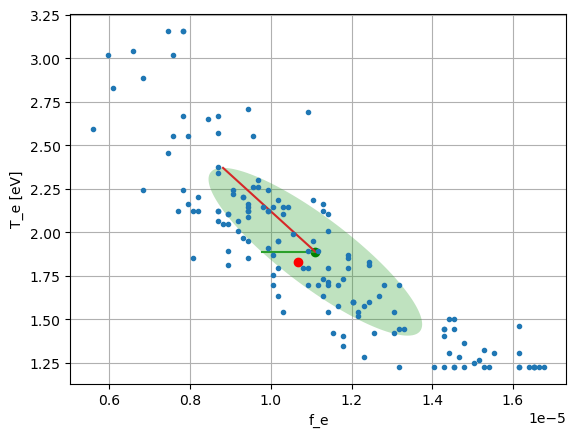

In [105]:
plt.plot( *min_avg, 'ro', label = 'True value' )
plt.plot( *avg_of_mins, 'go', label = 'Average +/- 1 std' )
corvec0, corvec1 = confel.confidence_ellipse( mins )
confel.plot_corrvec( np.mean( [ x for x,_ in mins ] ), np.mean( [ y for _,y in mins ] ), corvec0, corvec1 )
for k in range( chisquared.shape[-1] ):
    plt.plot( *mins[k], '.', color='tab:blue' )

plt.xlabel("f_e")
plt.ylabel("T_e [eV]")

splt.export( filename + "_correlation" )

./results/r003_r002_p002_correlation_projected.pdf


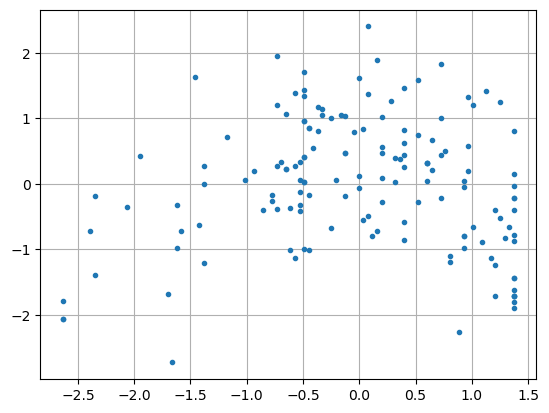

In [115]:
mins_projected, corvec0_projected, corvec1_projected = confel.project( mins - avg_of_mins, corvec0, corvec1 )
for k in range( chisquared.shape[-1] ):
    plt.plot( *mins_projected[k], '.', color='tab:blue' )
# confel.plot_corrvec( np.mean( [ x for x,_ in mins_projected ] ), np.mean( [ y for _,y in mins_projected ] ), corvec0_projected, corvec1_projected )
# confel.confidence_ellipse( mins_projected )

splt.export( filename + "_correlation_projected" )

./results/r003_r002_p002_correlation_histograms.pdf


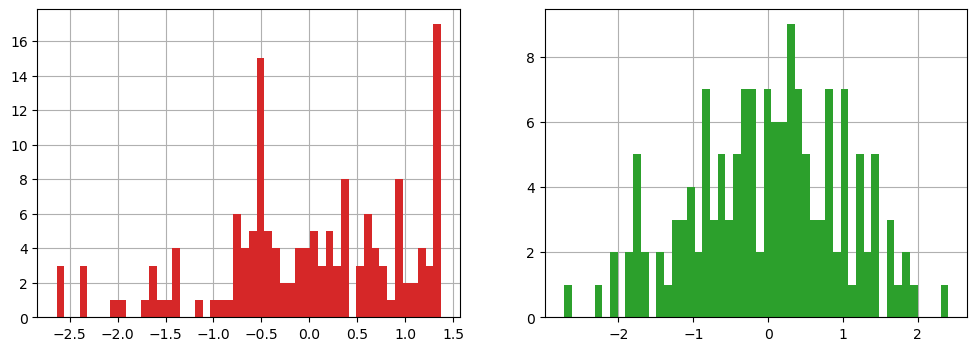

In [116]:
splt.init_bytot( 2 )

splt.next()
plt.hist( [ x for x,_ in mins_projected ], color = confel.vec_cols[1], bins=50 )
splt.next()
plt.hist( [ y for _,y in mins_projected ], color = confel.vec_cols[0], bins=50 )

splt.export( filename + "_correlation_histograms" )